In [1]:
# Packages
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from numpy import array, mean
from matplotlib.pyplot import savefig, xlim, ylim
from os import makedirs

In [2]:
# Load data and setup output dir
data = read_csv("data/anon.csv", sep="\t")
print(data)

makedirs("output", exist_ok=True)

                                   user_sha1  total_events  total_breaks  \
0   5787ea1cb8ec38d1fe05510b4472ed73ab995578           768            25   
1   e76056103a0f740752859aec222102e77af132a4            25             1   
2   61b6b2ed7c2d28f51122a5dcea07d30de9a8dfa7          1874            47   
3   ace95c14c44d1cce2494ba11d81c297259d09c9a          1660            55   
4   2c510471bfc0d07085c7988ba837397b849f12d9           567            17   
5   6b463921a37f03efe9c1713066edcfc1712589ed          8312            64   
6   f142534fbdc8f05525e44d69f5675648903ebeb8           983            10   
7   8fc2e33605f47244bd5e566654dd9581ce70c1c7           450            17   
8   8291ca26f6c191e3ef73734afdf522c566e1d6e5          1351            20   
9   08bf99a4fa7f3598061d191434db3a310999878e          1395            14   
10  4c5c23950f6faecf85533a7451e92c7b311e54a0           430            12   
11  908dd852e5b773e4c72082d66003b16bb0dad2a3           943            70   
12  7f74dc02

In [3]:
# Clean data
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

In [4]:
# Composite values
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)

In [5]:
# What columns do we care about and what dependent variable col are we trying to predict?
cols = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    "n_interm",
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    "diff_event2",
    # "diff_event3", # missing over 30 values
    "different_event",
    "sbst",
    "gender_number",
    "enjoyment",
    "sri"
]

dep_col = "sri"

In [6]:
# Display how many missing values are in each column
for col in cols:
  print(f"Variable: {col:20} Missing Values: {data[col].isna().sum()}")

Variable: total_events         Missing Values: 0
Variable: total_breaks         Missing Values: 0
Variable: total_submit         Missing Values: 0
Variable: total_snapshot       Missing Values: 0
Variable: total_view           Missing Values: 0
Variable: total_manipulate     Missing Values: 0
Variable: n_puzzle             Missing Values: 0
Variable: n_puz_no_basic       Missing Values: 0
Variable: p_puz_no_basic       Missing Values: 0
Variable: n_complete           Missing Values: 0
Variable: n_tutorial           Missing Values: 0
Variable: n_interm             Missing Values: 9
Variable: total_active         Missing Values: 0
Variable: complete_active      Missing Values: 2
Variable: incomplete_active    Missing Values: 3
Variable: tutorial_atime_comp  Missing Values: 2
Variable: cumu_a_time          Missing Values: 0
Variable: persistence_score    Missing Values: 0
Variable: non_per              Missing Values: 0
Variable: productive           Missing Values: 0
Variable: unproducti

In [7]:
# Drop empty data and split into labels and features
good_data = data[data["sri"] > 0][cols].dropna()
labels = array(good_data[dep_col])
features = array(good_data.drop(dep_col, axis=1))

In [8]:
# Split into train and test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)
print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Features Shape:", test_features.shape)
print("Testing Labels Shape:", test_labels.shape)

Training Features Shape: (22, 33)
Training Labels Shape: (22,)
Testing Features Shape: (8, 33)
Testing Labels Shape: (8,)


In [9]:
# Fit model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [10]:
# Check model error
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print("Mean Absolute Error:", round(mean(errors), 2), "degrees.")

Mean Absolute Error: 3.68 degrees.


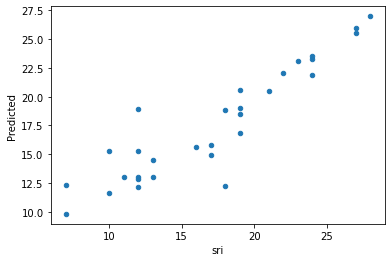

In [11]:
# Plot actual vs. predicted
good_data["Predicted"] = rf.predict(features)
good_data.plot(
    kind="scatter",
    x=dep_col,
    y="Predicted"
)

savefig("output/predicted.png")

In [12]:
# Display importance of each features
importances = list(rf.feature_importances_)
feature_importances = [
    (feature, round(importance, 2))
    for feature, importance
    in zip(list(data[cols].drop(dep_col, axis=1).columns), importances)
]

feature_importances = sorted(feature_importances, reverse=True, key=lambda x: x[1])
for feature, importance in feature_importances:
    print(f"Variable: {feature:20} Importance: {importance}")

Variable: sbst                 Importance: 0.61
Variable: n_complete           Importance: 0.03
Variable: n_interm             Importance: 0.03
Variable: cumu_a_time          Importance: 0.03
Variable: persistence_score    Importance: 0.03
Variable: rapid                Importance: 0.03
Variable: tutorial_atime_comp  Importance: 0.02
Variable: productive           Importance: 0.02
Variable: no_beh               Importance: 0.02
Variable: different_event      Importance: 0.02
Variable: total_events         Importance: 0.01
Variable: total_breaks         Importance: 0.01
Variable: n_puzzle             Importance: 0.01
Variable: n_puz_no_basic       Importance: 0.01
Variable: p_puz_no_basic       Importance: 0.01
Variable: complete_active      Importance: 0.01
Variable: incomplete_active    Importance: 0.01
Variable: non_per              Importance: 0.01
Variable: avg_revisit          Importance: 0.01
Variable: n_attempt            Importance: 0.01
Variable: n_failed_att         Importanc